# Analyzing CIA Factbook Data Using SQLite and Python

The [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/) is a compedium of statistics about all of the countries on Earth. It contains demographic information like:
 - `population` - The population as of `2015`
 - `population_growth` - The annual population growth rate, as a percentage
 - `area` - The total land and water area
 
The Factbook SQLite database, `factbook.db`, can be found at this [GitHub repo](https://github.com/factbook/factbook.sql/releases).

In [1]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('factbook.db')
q1 = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q1,conn)

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


In [2]:
q2 = "SELECT * FROM facts LIMIT 5"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## Summary Stastics
Now that we have found the right table to query and have previewed the data. Let's calculate some summary statistics!

In [3]:
q3 = '''
SELECT MIN(population) min_pop, MAX(population) max_pop, 
MIN(population_growth) min_pop_grwth, MAX(population_growth) max_grwth
FROM facts
'''
pd.read_sql_query(q3, conn)

,min_pop,max_pop,min_pop_grwth,max_grwth
0,0,7256490011,0.0,4.02


## Outliers
A few things stick out from the summary stastics in the last cell:
 - There's a country with a population of `0`
 - There's a country with a population of `7256490011` (or more than 7.2 billion people)

Let's zoom in on just these countries:

In [4]:
q4 = '''
SELECT * FROM facts
WHERE population == (SELECT MAX(population) FROM facts)
'''
pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


In [5]:
q5 = '''
SELECT * FROM facts
WHERE population == (SELECT MIN(population) FROM facts) 
'''
pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


## Observations
The CIA World Factbook contains a row for the entire planet, which excludes area informatoin but aggregates population, popluation growth, birth and death rates. The Factbook also contains a row for Antartica that has values for land area and population only, although since Antartica is uninhabited the population = 0.

## Histograms With Summary Statistics
Let's move on to generating histograms for the rest of the countries in the table, ignoring these 2 rows:

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02e3531160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f02e31fb278>]], dtype=object)

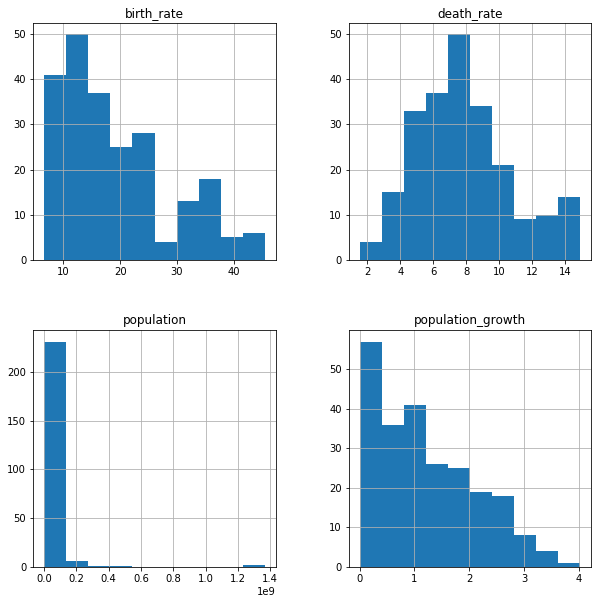

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q6 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE name NOT IN("World", "Antartica")
ORDER BY population
'''
pd.read_sql_query(q6, conn).hist(ax=ax)


# Further Exploration
We can continue to ask questions and look at the data in greater detail.

## What Countries Have the Highest Population Density?

In [7]:
q7 = '''
SELECT name, CAST(population AS Float) / CAST(area_land AS Float) Density
FROM facts
ORDER BY Density DESC
LIMIT 20
'''

pd.read_sql_query(q7, conn)

,name,Density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02e315de10>], dtype=object)

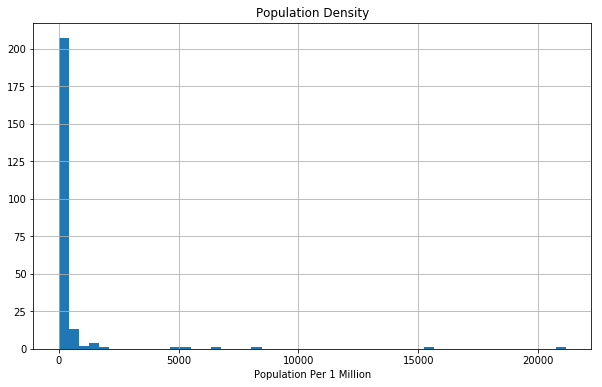

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Population Per 1 Million')

q8 = '''
SELECT CAST(population AS Float) / CAST(area_land AS Float) AS "Population Density"
FROM facts
'''

pd.read_sql_query(q8, conn).hist(ax=ax,bins=50)

## Which Countries Have The Highest Ratios of Water to Land?

In [9]:
q9 = '''
SELECT name, CAST(area_water AS Float) / CAST(area_land AS Float) AS "Water to Land Ratio"
FROM facts
ORDER BY "Water to Land Ratio" DESC
LIMIT 20 
'''
pd.read_sql_query(q9, conn)

,name,Water to Land Ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


## Which Countries Have More Water Than Land?

In [10]:
q10 = '''
SELECT name, area_land, area_water, area, ROUND((CAST(area_water AS Float) / CAST(area AS Float)*100),2) AS "% of Total Area that is Water"
FROM facts
WHERE area_water > area_land
'''
pd.read_sql_query(q10, conn)

,name,area_land,area_water,area,% of Total Area that is Water
0,British Indian Ocean Territory,60,54340,54400,99.89
1,Virgin Islands,346,1564,1910,81.88


In [11]:
# Closing connection the database - Explicit is better than implicit.
#conn.close()